Camacho Castelan Jose Manuel
S22002245

In [343]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import igraph
from igraph import Graph, EdgeSeq
import plotly.graph_objects as go
import math
import random

In [344]:
mov = 0.5 # tamanio de paso del robot
expandidos = []

origen = [5,0]
meta = [8,8]

In [345]:
def get_nodos(raiz):
    nodos = []
    por_visitar = [raiz]
    visitados = []

    while por_visitar != []:
        nodo = por_visitar.pop(0)
        if (nodo in visitados) or (nodo in nodos):
            continue
        nodos.append(nodo)
        por_visitar += nodo.hijos
        visitados.append(nodo)

    return nodos

In [346]:
def get_etiquetas(nodos):
    labels = []
    for nodo in nodos:
        labels.append(
            str(nodo.pos)
        )
    return labels

In [347]:
def crear_grafo(nodos, etiquetas):
    
    g = Graph(directed = True)

    for nodo in nodos:
        g.add_vertex(etiquetas[nodos.index(nodo)])
    padre_hijo = []
    for nodo in nodos:
        
        padre_hijo.append([nodo.papa, nodo])
    for r in padre_hijo:
        if r[0]:  # tiene papa
            g.add_edge(etiquetas[nodos.index(r[0])], etiquetas[nodos.index(r[1])])

    edges = [e.tuple for e in g.es]
    
    return g, edges

In [348]:
def dibujar_grafo(grafo, labels, title):
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        return f"SHay {len(raices)}, imposible ejecutar"
    root_idx = raices[0]

    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx]) # out, que no se graficque hacia los lados, sino hacia abajo

    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]  # y negativa: hacia abajo

    Xe, Ye = [], []
    for edge in grafo.get_edgelist():
        Xe += [Xn[edge[0]], Xn[edge[1]], None]
        Ye += [Yn[edge[0]], Yn[edge[1]], None]

    trace_edges = go.Scatter(
        x=Xe, y=Ye,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )

    trace_nodes = go.Scatter(
        x=Xn, y=Yn,
        mode="markers",
        marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
        text=labels,
        textposition="middle center",
        hoverinfo="text"
    )

    fig = go.Figure(data=[trace_edges, trace_nodes],
                    layout=go.Layout(title=title,
                                     showlegend=True,
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False),
                                     yaxis=dict(showgrid=False, zeroline=False)))
    fig.show()

In [349]:
def dibujar_grafo_anim(grafo, labels, title):
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        raise ValueError(f"Se esperaba 1 raíz, pero hay {len(raices)}")

    root_idx = raices[0]
    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx])
    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]

    # Preparar nodos y aristas para cada frame
    frames = []
    num_nodos = len(grafo.vs)
    for i in range(1, num_nodos + 1):
        # Aristas visibles hasta este nodo
        Xe, Ye = [], []
        for edge in grafo.get_edgelist():
            if edge[0] < i and edge[1] < i:
                Xe += [Xn[edge[0]], Xn[edge[1]], None]
                Ye += [Yn[edge[0]], Yn[edge[1]], None]

        trace_edges = go.Scatter(
            x=Xe, y=Ye,
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none"
        )

        trace_nodes = go.Scatter(
            x=Xn[:i], y=Yn[:i],
            mode="markers",
            marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
            text=labels[:i],
            textposition="middle center",
            hoverinfo="text"
        )

        frames.append(go.Frame(data=[trace_edges, trace_nodes], name=str(i)))

    # Frame inicial
    initial_edges = go.Scatter(x=[], y=[], mode="lines")
    initial_nodes = go.Scatter(x=[], y=[], mode="markers")

    fig = go.Figure(
        data=[initial_edges, initial_nodes],
        layout=go.Layout(
            title=title,
            showlegend=True,
            margin=dict(b=20, l=7, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False),
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label=" > Reproducir",
                              method="animate",
                              args=[None, {"frame": {"duration": 500, "redraw": True},
                                           "fromcurrent": True, "transition": {"duration": 0}}])],
                showactive=False,
                x=0.1, y=-0.1
            )]
        ),
        frames=frames
    )

    fig.show()

In [350]:
def dibujar(gp):
    plt.grid(True)
    plt.scatter(gp[0], gp[1], c="r") # dibula la posicion del punto
    plt.plot([0,0,10, 10,0], [0,10,10,0,0], c="k") # dibujamos un cuadro delimitando el espacio de trabajo

In [351]:
class Obstaculo():
    def __init__(self, v1, v2):
        self.v1 = v1 # esquina superior
        self.v2 = v2 # esquina inferior

    def en_colision(self, punto):
        if self.v1[0] <= punto[0] <= self.v2[0] and self.v2[1] <= punto[1] <= self.v1[1]:
            return True
        return False
    
    def dibuja(self):
        x = [self.v1[0], self.v2[0], self.v2[0], self.v1[0], self.v1[0]]
        y = [self.v1[1], self.v1[1], self.v2[1], self.v2[1], self.v1[1]]
        plt.plot(x,y, "--k")

In [352]:
obstaculos = [
    Obstaculo([6,7],[7.5,2]),
    Obstaculo([5,9],[7,7]),
    Obstaculo([4,6],[5,4]),
    Obstaculo([7.5,6],[8.5,2]),
    Obstaculo([2,6],[3,4]),
    Obstaculo([2,3],[2.5,2]),
    Obstaculo([2,2.5],[4.5,2]),

]

In [353]:
def es_punto_valido(punto, obstaculos, limites):
    # esta en el limite permitido?
    if limites[0] <= punto[0] <= limites[2] and limites[1] <= punto[1] <= limites[3] :
        # Hay colision
        for o in obstaculos:
            if o.en_colision(punto):
                return False
        return True
    return False

In [354]:
class Nodo():
    def __init__(self, pos, papa = None):
        global expandidos
        self.pos = pos
        self.hijos = []
        self.papa = papa
        if self not in expandidos:
            expandidos.append(self)

    def genera_hijos(self, obstaculos, limites):
        global expandidos
        
        # uno arriba
        pos_arriba = self.pos[:]
        pos_arriba[1] += mov

        # uno abajo
        pos_abajo = self.pos[:]
        pos_abajo[1] -= mov
        
        # uno izq
        pos_izq = self.pos[:]
        pos_izq [0] -= mov
        
        # uno der
        pos_der = self.pos[:]
        pos_der[0] += mov
        
        if es_punto_valido(pos_arriba, obstaculos, limites):
            hijo = self.__class__(pos_arriba, self)
            self.hijos.append(hijo)

        if es_punto_valido(pos_abajo, obstaculos, limites):
            hijo = self.__class__(pos_abajo, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_izq, obstaculos, limites):
            hijo = self.__class__(pos_izq, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_der, obstaculos, limites):
            hijo = self.__class__(pos_der, self)
            self.hijos.append(hijo)

    def __eq__(self, n2):
        return self.pos == n2.pos

    def __str__(self):
        s = f"[{self.pos[0]}, {self.pos[1]}]"
        return s

    def rrt(self, meta, robot, max_iter=1000):
        global expandidos
        nodos = [self]
        for iter in range(max_iter):
            # generar punto aleatorio
            r_x = random.randint(robot.limites[0], robot.limites[2])
            r_y = random.randint(robot.limites[1], robot.limites[3])
            r_P = [r_x, r_y] # random point 

            # encontrar nodo más cercano al punto aleatorio
            N_c = min(nodos, key=lambda n: math.dist(n.pos, r_P)) # closest node

            # vector hacia el punto aleatorio
            v = np.array(r_P) - np.array(N_c.pos) # vector

            h = np.linalg.norm(v) # hypotenuse

            if h == 0:  # X o Y infinitos
                continue
            v = (v / h) * mov

            n_P = list(np.array(N_c.pos) + v) # nuevo punto

            # es válido?
            if es_punto_valido(n_P, robot.obstaculos, robot.limites):
                N_N = Nodo(n_P, N_c) # nuevo nodo
                N_c.hijos.append(N_N)
                nodos.append(N_N)
                expandidos.append(N_N)

                # esta cerca de la meta (a un movimiento de distancia)?
                if math.dist(n_P, meta) < mov:
                    meta_nodo = Nodo(meta, N_N)
                    N_N.hijos.append(meta_nodo)
                    nodos.append(meta_nodo)
                    expandidos.append(meta_nodo)

                    camino = []
                    papa = meta_nodo
                    while papa:
                        camino.append(papa)
                        papa = papa.papa
                    camino.reverse()
                    print(f"Encontrado a las {iter} de {max_iter} iteraciones")
                    return camino
        return None

        
    def rrt2(self, meta, robot, max_iter=1000):
        global expandidos
        camino = [self]

        def trayectoria_valida(a, b):
            dx = abs(a[0] - b[0])
            dy = abs(a[1] - b[1])
            pasos = int(max(dx, dy) * 2)  # mayor resolución si mov=2

            puntos = []
            for i in range(pasos + 1):
                x = a[0] + (b[0] - a[0]) * i / pasos
                y = a[1] + (b[1] - a[1]) * i / pasos
                punto = [round(x), round(y)]

                if es_punto_valido(punto, robot.obstaculos, robot.limites):
                    puntos.append(punto)
                else:
                    return False  # Si un punto no es válido, descartamos todo
            return puntos  # Trayectoria completa válida

        iteraciones = 0
        while iteraciones < max_iter:
            iteraciones += 1
            # Generar punto aleatorio en el espacio
            r_p = [random.randint(robot.limites[0], robot.limites[2]),
                random.randint(robot.limites[1], robot.limites[3])]

            # Intentar conectar el último punto del camino hacia el aleatorio
            puntos_trayectoria = trayectoria_valida(camino[-1].pos, r_p)
            if puntos_trayectoria:
                nuevo_nodo = Nodo(r_p, camino[-1])
                expandidos.append(nuevo_nodo)
                camino.append(nuevo_nodo)

                # Si se puede llegar desde este nuevo nodo a la meta, finalizamos
                if trayectoria_valida(r_p, meta):
                    camino.append(Nodo(meta, camino[-1]))
                    return camino

        print("No se encontró un camino en", max_iter, "iteraciones.")
        return camino  # Puede estar incompleto


In [355]:
class Robot():
    def __init__(self, pos = [5,5], limites = [0,0,10,10], obstaculos = []):
        self.pos = pos
        self.limites = limites
        self.obstaculos = obstaculos
        self.trajectory = []
        self.raiz = Nodo(pos)

        if self.raiz not in expandidos:
            expandidos.append(self.raiz)
    
    def agrega_obstaculo(self, obs):
        self.obstaculos.append(obs)

    def plot_robot(self):
        plt.scatter(self.pos[0], self.pos[1], c="b")

    def RRT(self):
        self.raiz = Nodo(self.pos)
        camino = self.raiz.rrt(meta, self)
        self.trajectory = []
        for paso in camino:
            self.trajectory += paso.pos
        return camino
    
        

In [356]:
def plot_space_simple(robot, expandidos, title):
    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    robot.plot_robot()

    for p in expandidos:
        plt.scatter(p.pos[0], p.pos[1], c="k")

    plt.plot(robot.trajectory[0::2], robot.trajectory[1::2], "o-b")

    dibujar([8,8])

    plt.title(title)
    plt.grid(visible=True)


In [357]:
def plot_space_animado(robot, expandidos, title):
    # Creamos la figura y los ejes
    fig, ax = plt.subplots()

    x_points = robot.trajectory[0::2]
    y_points = robot.trajectory[1::2]
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)

    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    

    # Línea inicial vacía
    line, = ax.plot([], [], "o-b")
    exp = ax.scatter([], [])
    


    # Función de inicialización
    def init():
        line.set_data([], [])
        exp.set_offsets(np.empty((0, 2)))
        dibujar(meta)
        robot.plot_robot()
        return line,

    def update(frame):

        x_data = x_points[:frame]
        y_data = y_points[:frame]
        line.set_data(x_data, y_data)

        x_exp = []
        y_exp = []

        porcentaje = frame / len(x_points)
        num_expandidos = int(len(expandidos) * porcentaje)

        for nodo in expandidos[:num_expandidos]:
            x_exp.append(nodo.pos[0])
            y_exp.append(nodo.pos[1])
        exp.set_color("y")
        exp.set_offsets(np.c_[x_exp, y_exp])
        
        return line, exp

    # Creamos la animación
    ani = FuncAnimation(
        fig, update, frames=len(x_points),
        init_func=init, blit=True, interval=100
    )

    plt.title(title)
    plt.grid(visible=True)
    # Mostramos la animación
    plt.show()

In [358]:
def ejecutar_RRT():
    robot = Robot(pos=origen, limites=[0, 0, 10, 10], obstaculos=obstaculos)
    camino = robot.RRT()
    print(f"expandidos {len(expandidos)}")
    for nodo in camino:
        print(nodo)

    # Dibuja el espacio y la trayectoria
    plot_space_simple(robot, expandidos, "RRT ")
    # O animación
    plot_space_animado(robot, expandidos, "RRT Animado")

Encontrado a las 305 de 1000 iteraciones
expandidos 403
[5, 0]
[5.1581138830084186, 0.4743416490252569]
[5.582230834995176, 0.7391525457751112]
[5.739492976191536, 1.213777259571534]
[6.225561140653537, 1.3309853629455808]
[6.717887212690114, 1.418249552582768]
[6.940809001105472, 1.8658049974716648]
[7.401724518553484, 1.6720090073799425]
[7.89778774347634, 1.7346291070216378]
[8.383897203761965, 1.8516658218628295]
[8.612231415575513, 2.2964843103673944]
[8.928029427665003, 2.6841331405737128]
[8.955335824015371, 3.1833869444834644]
[8.963263530199415, 3.68332409200769]
[9.02088039558806, 4.179993294619234]
[9.017178308073541, 4.679979588979425]
[9.010672024726023, 5.1799372554643]
[8.622406736874998, 5.494977040650172]
[8.960001151172932, 5.863799506661713]
[8.977592274526197, 6.363489963223743]
[8.980673154251946, 6.863480471313762]
[8.989174570812876, 7.363408192005921]
[9.251919000286902, 7.7888084326974]
[9.412155146220055, 8.26243737769178]
[9.168249969744231, 8.698912193561261

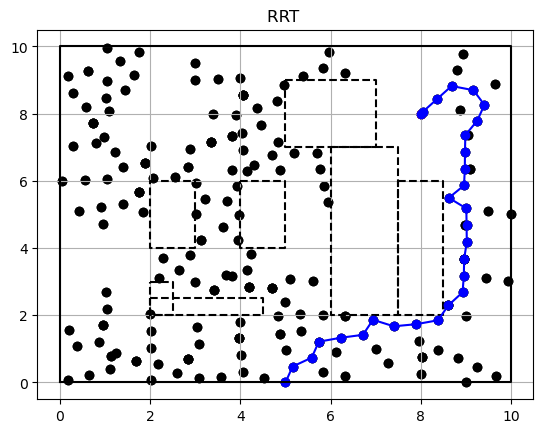

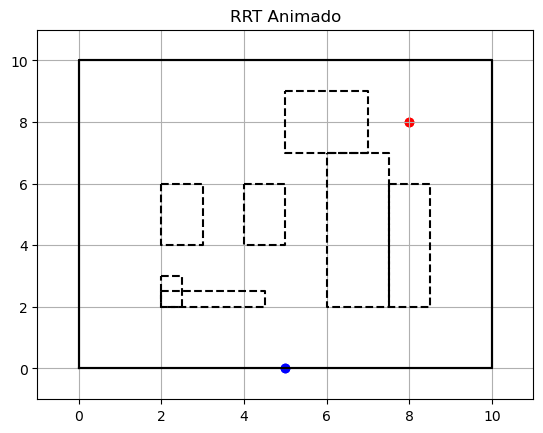

In [359]:
ejecutar_RRT()